In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt

from rocketPy import Quaternion

In [2]:
class SimpleRocket():
    
    def __init__(self):
        
        self.m0 = 40;
        self.c = 2000;
        
        self.A_ref = np.pi*0.15**2/4;
        
        self.ax_roll = np.array([0,0,1])
        self.ax_pitch = np.array([0,1,0])
        self.ax_yaw = np.array([1,0,0])
        
        self.inertia_matrix = np.diag([100,100,10])
        
    def dynamics(self, time, state):
        
        # need to return the forces and moments acting at the cg in body fixed axes.
        # z points towards the nose
        # x points to the right fin
        # y completes right hand coord system
        
        # m_dot is a scalar, negative if the mass is decreasing
        
        # compute thrust force
        f_thrust, m_dot = self.f_thrust(time, state)
        
        # compute axial drag force
        f_axial = self.f_axial(time, state)
        
        
        
        # sum forces
        forces = f_thrust + f_axial;

        # sum moments
        moments = np.array([0,0,0])
        
        return forces, moments, m_dot
    
    
    def f_thrust(self, time, state):
        if time < 3:
            f = 1000;
        else:
            f = 0;
        
        m_dot = -f/self.c
        
        return f*self.ax_roll, m_dot
        
    def f_axial(self, time, state):
        
        C_A = 0.5;
        q_inf = self.dynamic_pressure(state);
        F_A = q_inf * C_A * self.A_ref;
        
        # is aligned with negative z axis
        F_A = np.array([0,0, -F_A]);
        
        return F_A
    
    def f_normal(self, time, state):
        
        C_Na = 9; # arbitrary for now
        
        return np.array([0,0,0])
        
    
    ## these are implementation specific
    ## ie as a person designing the rocket, you need to define how you determine the aero forces, 
    ## so you own these equations
    ## the state just interfaces bewteen scipy solve ivp and rocket dynamics
    
    
        
        
    def dynamic_pressure(self, state):
        z = state.pos[2]
        
        # todo update to use the cp velocity
        dynamic_pressure = 0.5 * state.env.rho(z) * self.v_cp(state) @ self.v_cp(state)
        
        return dynamic_pressure
    
    def v_body(self, state):
        """Returns the velocity of the body in earth coordinates"""
        
        return state.momentum/state.mass;
    
    def v_cg(self, state):
        """Returns the apparent airspeed at the CG in earth coordinates
        v_cg = v_body + wind
        """
        return self.v_body(state) + state.wind()
    
    def v_p(self, p):
        """Computes the airspeed at some location p.
        p is the position vector of the point relative to the cg of the rocket in earth coordinates
        """
        # todo (high): update with 6DOF
        omega = np.array([0,0,0])
        # todo convert p to earth coordinates
        
        return v_cg() + np.cross(omega, p)
        
        
    def v_cp(self, state):
        """Returns the apparent airspeed at the CP
        accounts for the rotation rate of the body
        """
        
        #todo (high): update to account for the rotation rate
        
        return self.v_cg(state)
        
    def alpha(self, p=None):
        """Return the angle of attack of the air at some location on the body p (relative to the cg)"""
        
        
        # angle between roll axis and airspeed at p
        # if p is none, use the cp
        
        
        raise NotImplementedError
    

In [3]:
class Env():
    
    def __init__(self):
        return
    
    def rho(self, z):
        """ Return the density at some altitude in meters"""
        return 1.225

In [4]:
class State():
    
    def __init__(self):
        
        zero = np.array([0,0,0]);
        
        self.time = 0;
        self.mass = 1;
        self.pos = zero;
        self.momentum = zero
        self.quaternion = Quaternion(1,0,0,0) #no rotation
        self.angular_momentum = zero;

        
        self.env = Env()
    
    def vector(self):
        """Convert state to vector"""
        # passes the quaternion's vector
        return np.hstack([[self.mass], self.pos, self.momentum, self.quaternion.q, self.angular_momentum]);
    
    def update(self,statev, time=None):
        # take a state vector and pass it to the internal objects
        if time is not None:
            self.time = time
            
        self.mass = statev[0]  
        self.pos = statev[1:4]
        self.momentum = statev[4:7]
        self.quaternion = Quaternion(*statev[7:11])
        self.angular_momentum = statev[11:14]
        
        
    def wind(self):
        """Returns the Earth coordinate wind vector at this state"""
        # maybe allow it to take some offset vector?
        # in either Earth or Body axes?
        
        # should be a deterministic function of state
        # for now a constant with time and altitude, blowing to the negative x direction
        return np.array([-5,0,0])
    
    
    def __repr__(self):
        return f'State  {self.v()}'

In [13]:
class Simulation():
    
    def __init__(self, rocket, state_initial):

        self.rocket = rocket
            
        self.ax_x = np.array([1,0,0])
        self.ax_y = np.array([0,1,0])
        self.ax_z = np.array([0,0,1]) # vertically upwards
        
        self.g0 = 9.81;
        self.g  = - self.g0*self.ax_z
        
        self.state = state_initial;
        
        self.launch_rail_length = 5;
        
        self.launch_angle = 6*np.pi/180
        self.launch_v = np.array([np.sin(self.launch_angle), 0, np.cos(self.launch_angle)])
        
        self.state.quaternion = Quaternion.from_angle(self.launch_angle, self.ax_y)
        
    
    def dynamics(self, time, statev):
        
        state = self.state;
        
        state.update(statev, time)
        
        # calculate the angular velocity of the rocket
        R = state.quaternion.rot_matrix()
        omega = R @ la.inv(self.rocket.inertia_matrix) @ R.T @ state.angular_momentum;
        # this omega is in earth coordinates, about the cg
        
        
        # get the rocket axis forces and moments
        forces_b, moments_b, m_dot = self.rocket.dynamics(time, state)
        
        # convert body axis forces into earth axis
        px, py, pz = state.momentum;
        th = np.arctan2(px,pz)
        R = np.array([[np.cos(th), 0, np.sin(th)],[0,1,0],[-np.sin(th), 0, np.cos(th)]])
        
        forces_e = R @ forces_b;
        moments_e = R @ moments_b;
        
        # add gravity
        forces = forces_e + state.mass*self.g;
        moments = moments_e;
        
        
        # apply launch rail
        # compute v_cg
        V_cg = self.state.momentum/self.state.mass;
        if la.norm(state.pos) < self.launch_rail_length:
            V_cg = self.launch_v * np.dot(V_cg, self.launch_v);
            forces = self.launch_v * np.dot(forces, self.launch_v);
        
        # determine rate of change of quaternion
        d_quaternion = state.quaternion.rate_of_change(omega)
        
        # set derivatives
        d_mass = m_dot
        d_pos = V_cg
        d_momentum = forces;
        #d_quaternion = d_quat
        d_angular_momentum = moments;
        
        return np.hstack([d_mass, d_pos, d_momentum, d_quaternion, d_angular_momentum])
    
    
    def solve(self, t_span = [0,100]):
        # set initial state
        s0 = self.state.vector()
        
        # when im no longer at the rail
        def no_rail(t, y):
            pos = la.norm(y[1:4]) - self.launch_rail_length;
            return pos
        no_rail.terminal = False
        no_rail.direction = 1;
        
        def apogee(t, y):
            return y[6]
        apogee.terminal = False
        apogee.direction = -1;
        
        def landing(t, y):
            return y[3]
        landing.terminal = True
        landing.direction = -1;
        
        self.sim_result = spint.solve_ivp(self.dynamics, t_span, s0, dense_output=True, events=(no_rail, apogee,landing));
        
        self.output = self.sim_result.sol;
        
        return self.sim_result
        
        
    
        

In [14]:
r = SimpleRocket()

In [15]:
s0 = State()
s0.mass = 40;


In [16]:
sim = Simulation(r, s0)

In [17]:
sim.g

array([-0.  , -0.  , -9.81])

In [18]:
r.dynamics(0, sim.state)

(array([  0.        ,   0.        , 999.86470289]), array([0, 0, 0]), -0.5)

In [20]:
sol = sim.solve()

In [21]:
sol;

Text(0.5, 1.0, 'Ang Mom')

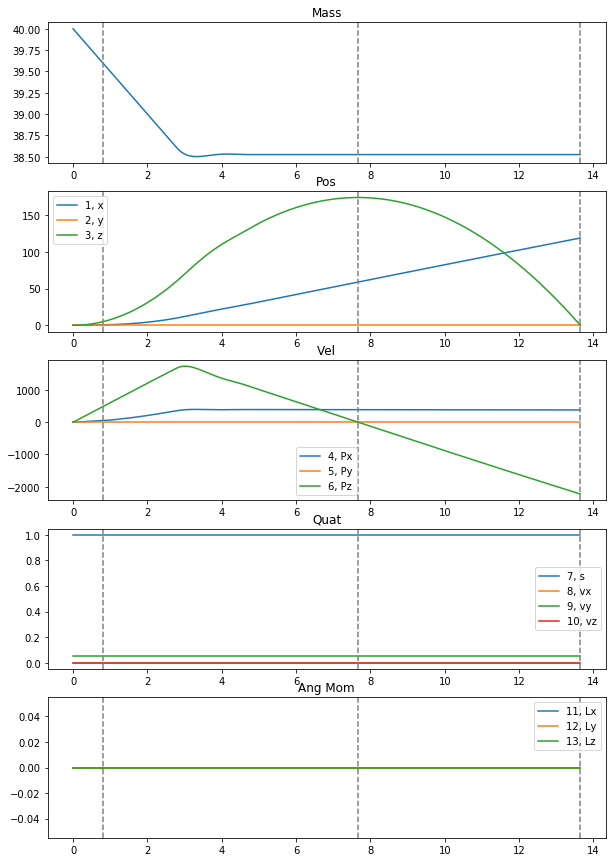

In [30]:
t_eval = np.linspace(sol.t[0], sol.t[-1], 500)


plt.figure(figsize=(10,15))
plt.subplot(511)
plt.plot(t_eval,sol.sol(t_eval)[0])

for t in sol.t_events:
    plt.axvline(t, color='gray',linestyle='--')
    
plt.title('Mass')



plt.subplot(512)
plt.plot(t_eval,sol.sol(t_eval)[1], label='1, x')
plt.plot(t_eval,sol.sol(t_eval)[2], label='2, y')
plt.plot(t_eval,sol.sol(t_eval)[3], label='3, z')
for t in sol.t_events:
    plt.axvline(t, color='gray',linestyle='--')
plt.legend()
plt.title('Pos')



plt.subplot(513)
plt.plot(t_eval,sol.sol(t_eval)[4], label='4, Px')
plt.plot(t_eval,sol.sol(t_eval)[5], label='5, Py')
plt.plot(t_eval,sol.sol(t_eval)[6], label='6, Pz')
for t in sol.t_events:
    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Vel')



plt.subplot(514)
plt.plot(t_eval,sol.sol(t_eval)[7], label='7, s')
plt.plot(t_eval,sol.sol(t_eval)[8], label='8, vx')
plt.plot(t_eval,sol.sol(t_eval)[9], label='9, vy')
plt.plot(t_eval,sol.sol(t_eval)[10], label='10, vz')
for t in sol.t_events:
    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Quat')



plt.subplot(515)
plt.plot(t_eval,sol.sol(t_eval)[11], label='11, Lx')
plt.plot(t_eval,sol.sol(t_eval)[12], label='12, Ly')
plt.plot(t_eval,sol.sol(t_eval)[13], label='13, Lz')
for t in sol.t_events:
    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Ang Mom')

/Users/Devansh/.virtualenvs/rocketPy/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


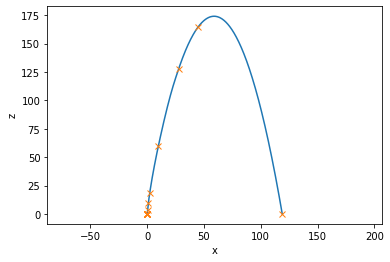

In [31]:
plt.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
plt.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

plt.axes().set_aspect('equal', 'datalim')

In [ ]:
plt.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
plt.plot(sol.y[1], sol.y[3],'x')


plt.xlabel('x')
plt.ylabel('z')


xrail = [0, sim.launch_rail_length*np.sin(sim.launch_angle)]
zrail = [0, sim.launch_rail_length*np.cos(sim.launch_angle)]

xrail2 = [0, 10*sim.launch_rail_length*np.sin(sim.launch_angle)]
zrail2 = [0, 10*sim.launch_rail_length*np.cos(sim.launch_angle)]


plt.plot(xrail, zrail)

plt.ylim(-3,20)
plt.xlim(-3,2)


In [ ]:
t_eval;

In [ ]:
angle = 180*np.arctan2(sol.sol(t_eval)[4], sol.sol(t_eval)[6])/np.pi
angle_m = 180*np.arctan2(sol.y[4], sol.y[6])/np.pi

plt.plot(t_eval,angle, '-',label='angle')
plt.plot(sol.t,angle_m,'x', label='angle')
for t in sol.t_events:
    plt.axvline(t,linestyle='--',color='gray')
    
plt.legend()
plt.title('angle')
#plt.xlim(0,3)
#plt.ylim(0,12)

In [ ]:
sol.sol(t_eval)